<a href="https://colab.research.google.com/github/nandhukumar86/GL-hackathons-1/blob/main/GL_hackathon_1_Nandha_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Basic Imports

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline


# Load the dataset

In [3]:
fd_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/frequency_domain_features_train.csv')
fd_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/frequency_domain_features_test.csv')
td_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/time_domain_features_train.csv')
td_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/time_domain_features_test.csv')
hr_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/heart_rate_non_linear_features_train.csv')
hr_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/heart_rate_non_linear_features_test.csv')

HR is the the column to be predicted

#Check of distinct uuid

In [4]:
fd_train['uuid'].value_counts().size, td_train['uuid'].value_counts().size, hr_train['uuid'].value_counts().size

(369289, 369289, 369289)

In [5]:
fd_test['uuid'].value_counts().size, td_test['uuid'].value_counts().size, hr_test['uuid'].value_counts().size

(41033, 41033, 41033)

This shows all has unique values

In [6]:
df3 = pd.merge(fd_train, td_train, how='outer', on='uuid')
df_train = pd.merge(df3, hr_train, how='outer', on='uuid')

In [7]:
df_train.shape

(369289, 37)

In [8]:
df2 = pd.merge(fd_test, td_test, how='outer', on='uuid')
df_test = pd.merge(df2, hr_test, how='outer', on='uuid')

In [9]:
df_test.shape

(41033, 36)

In [10]:
y_train = df_train.pop('HR')

In [11]:
X_train = df_train.copy(deep = True)
X_test = df_test.copy(deep = True)

In [12]:
X_train.shape, X_test.shape

((369289, 36), (41033, 36))

#Checking the distribution of heartrate

1. All HR are positive values.
2. Right Sckewed, can bring in log transform to make normalized. Will check that.


## Why log?

  y = exp(log(y))

A model will perform better if the data is normally distributed. Since our HR is not normal we will make it normal by log, and say y_norm [check the values]. Train the model with y_norm, predict the y_norm for test data, then during submit take the expo of y_norm to get the yhat.


# Some basic EDA

## Drop datasetId

datasetId contains same values and it doesnot provide any additional information to the model. Hence we will drop the column in both test and train dataset.

In [13]:
X_train.drop(columns= ['datasetId'], inplace=True)
X_test.drop(columns= ['datasetId'], inplace=True)

In [14]:
df_train.condition.value_counts()

no stress        200082
interruption     105150
time pressure     64057
Name: condition, dtype: int64

In [15]:
df_test.condition.value_counts()

no stress        22158
interruption     11782
time pressure     7093
Name: condition, dtype: int64

In [16]:
X_train.drop(columns= ['uuid'], inplace=True)

In [17]:
y_id = X_test.pop('uuid')

### Some Interesting features, just forget about the high corr features.!! May be thats wrong.

1. VLF_PCT = (VLF)/(VLF+HF+LF)
2. LF_PCT = (LF)/(VLF+HF+LF)
3. HF_PCT = 100 - (VLF_PCT + LF_PCT)


Are we going to process the raw data or computed data????

Interesting Formula and calculations!!!!!

1. HF_NU = HF/(HF+LF)
2. LF_NU = LF/(HF+LF)

And ofcource 
1. TP = VLF + LF + HF
2. LF_HF = LF / HF
3. HF_LF = HF / LF

Raw data : VLF, LF, HF, all others are computed or derived data!!

The question here is are we going to use raw data or computed data.


Can drop SKEW_REL_RR and KURT_REL_RR

In [18]:
X_train.drop(columns= ['SKEW_REL_RR','KURT_REL_RR'], inplace=True)
X_test.drop(columns= ['SKEW_REL_RR','KURT_REL_RR'], inplace=True)

In [19]:
X_train.drop(columns= ['SDSD_REL_RR'], inplace=True) 
X_test.drop(columns= ['SDSD_REL_RR'], inplace=True) 

In [20]:
X_train.shape, X_test.shape

((369289, 31), (41033, 31))

In [21]:
X_train.columns

Index(['VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU',
       'TP', 'LF_HF', 'HF_LF', 'MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD',
       'SDRR_RMSSD', 'pNN25', 'pNN50', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDRR_RMSSD_REL_RR',
       'SD1', 'SD2', 'sampen', 'higuci', 'condition'],
      dtype='object')

In [22]:
import statsmodels.api as sm

cols = ['VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU',
       'TP', 'LF_HF', 'HF_LF', 'MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD',
       'SDRR_RMSSD', 'pNN25', 'pNN50', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDRR_RMSSD_REL_RR',
       'SD1', 'SD2', 'sampen', 'higuci']

from sklearn.linear_model import Lasso

model = Lasso()

model.fit(X_train[cols], y_train)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [40]:
model.coef_ * 10000

array([-7.30171992e-01, -8.23186587e+01, -7.63112782e+00,  0.00000000e+00,
       -0.00000000e+00,  1.51556375e+02,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  2.28945225e+01,  0.00000000e+00, -1.02400215e+03,
        1.27110537e+02,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  3.09092461e+02,
       -0.00000000e+00, -0.00000000e+00])

In [43]:
col2 = pd.DataFrame(model.coef_ * 10000,np.array(cols))
col2.columns = ['val']

In [50]:
final_cols = col2[col2['val']!=0].index

In [54]:
X_train[final_cols].head()

X_train = X_train[final_cols]
X_test = X_test[final_cols]

In [59]:
X_train['condition'] = hr_train['condition']
X_test['condition'] = hr_test['condition']

# Heat Map

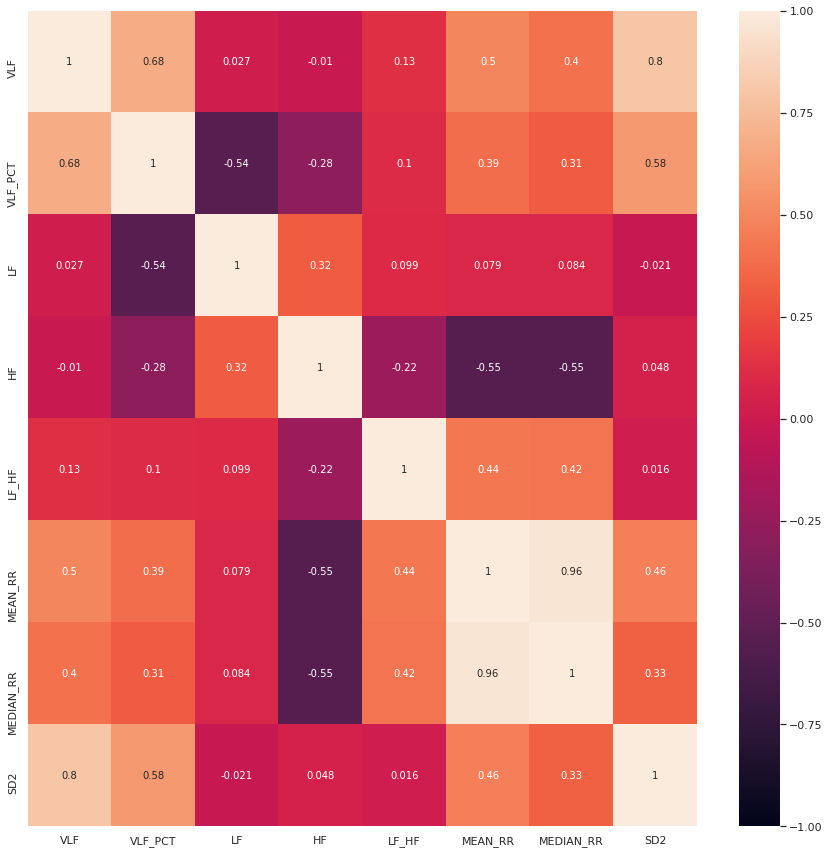

In [55]:
plt.figure(figsize=(15,15))
sns.heatmap(X_train.corr(), annot=True, vmin = -1, vmax = 1)


# Pair Plot

In [ ]:
# sns.pairplot(df_train, corner=True)

In [60]:
X_train.columns

Index(['VLF', 'VLF_PCT', 'LF', 'HF', 'LF_HF', 'MEAN_RR', 'MEDIAN_RR', 'SD2',
       'condition'],
      dtype='object')

In [61]:
categorical_columns = X_train.describe(include = ['O']).columns
numerical_columns = X_train.describe().columns

In [63]:
X_train.columns.size, X_test.columns.size

(9, 9)

In [64]:
categorical_columns.size +  numerical_columns.size

9

# Pipeline

In [65]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

pl_n = Pipeline([
                #  ('imputerNaN', SimpleImputer(missing_values=np.nan, strategy='median')),
                #  ('imputer0', SimpleImputer(missing_values=0, strategy='median')),
                 ('std', StandardScaler()),
                 ('power', PowerTransformer())
])

pl_c = Pipeline([
                #  ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                 ('std', OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([
                        ('num', pl_n, numerical_columns),
                        ('cat', pl_c, categorical_columns)
])

In [ ]:
! pip install catboost

     |████████████████████████████████| 66.3MB 57kB/s 


In [66]:
from sklearn.metrics import mean_absolute_error

# Decision Regression

In [ ]:
!pip install xgboost

In [69]:
from sklearn.tree import DecisionTreeRegressor

model = Pipeline([
               ('ct', ct),
               ('lr', DecisionTreeRegressor(random_state=1))
])

model.fit(X_train, y_train)

y_test_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)


print('Training Score: ', '%0.8f'%mean_absolute_error(y_train, y_train_predict))


Training Score:  0.00005083


# Catboost

In [73]:
!pip install catboost

     |████████████████████████████████| 66.3MB 54kB/s 


In [74]:
from catboost import CatBoostRegressor

model = Pipeline([
               ('ct', ct),
               ('lr', CatBoostRegressor(verbose = False))
])

model.fit(X_train, y_train)

y_test_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)


print('Training Score: ', '%0.8f'%mean_absolute_error(y_train, y_train_predict))


Training Score:  0.08749473


In [77]:
from sklearn.neighbors import KNeighborsRegressor

model = Pipeline([
               ('ct', ct),
               ('lr', KNeighborsRegressor(n_neighbors = 3 , weights = 'distance'))
])

model.fit(X_train, y_train)

y_test_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)


print('Training Score: ', '%0.8f'%mean_absolute_error(y_train, y_train_predict))


Training Score:  0.00000000


In [79]:
from sklearn.ensemble import RandomForestRegressor

model = Pipeline([
               ('ct', ct),
               ('lr', RandomForestRegressor(n_estimators = 50, random_state=1))
])

model.fit(X_train, y_train)

y_test_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)


print('Training Score: ', '%0.8f'%mean_absolute_error(y_train, y_train_predict))



Training Score:  0.00264765


In [70]:
y_test_predict

array([64.70793676, 73.78044802, 69.19700677, ..., 60.96336854,
       77.41383485, 76.61011118])

In [80]:
df = pd.concat([pd.DataFrame(y_id),pd.DataFrame(y_test_predict)], axis=1, ignore_index=True)
df.columns = ['uuid','HR']
df.to_csv('/content/drive/MyDrive/Colab Notebooks/GL_Hackathon/Submission1.csv', index=False)
